What is the purpose of an autoencoder and why do we use this model?

Autoencoders serve several useful functions such as data compression, denoising data, identifying anomalous data, and extracting features. They are a type of neural network model that operates on unsupervised learning principles. Their design involves encoding input data into a latent space and subsequently decoding it to generate an output.

Our objectives when using autoencoders are twofold:

    Minimize the loss function.
    Create a generative model that produces outputs closely resembling the input.

The fundamental concept behind autoencoders revolves around utilizing convolution layers (nn.Conv2d) in combination with transposed convolutions or inverse operations (ConvTranspose2d) to construct the model.

In [ ]:
# install this module for extracting info from fas file instead of doing by hand
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from Bio import SeqIO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam


# hyperparameters
sequence_length = 146
input_dim = (sequence_length, 21)  # Amino acids encoded using one-hot encoding
encoding_dim = 32
decode_dim = 0
Optimizer = 'adam'
Loss = 'binary_crossentropy'
#after applying 100 epochs, the loss didnt changed that mouch after the 80th epoch
Epochs = 80
Batch_size = 16
#We dont need validation data cause its unsupervised

In [ ]:
# Define the list of amino acids
Amino_Acids = list('ACDEFGHIKLMNPQRSTVWY-')
#load the file
print(Amino_Acids)
#we can read any file we want but for experiment, we choose this one
file_name = "CSPD_IF1_20_id90.fas"

# Start reading our files
def read_fas_file(filename):
    sequence = {}
    for record in SeqIO.parse(filename , "fasta"):
        sequence[record.id] = str(record.seq)
    return sequence

#for simplisity, we will use a prefixed length for
#sequence_length = get_sequence_length(fasta_file_path)


['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']


'\ndef get_sequence_length(file_name):\n    sequence = read_fas_file(fasta_file_path)\n    new_len = len(sequence)\n    return new_len\n'

Based on the code below, we can have a better understanding of our sequences variable.
the sequences is a dictionary with name of the sequence as its key and the sequence itself as value.

we need to encode and work with values in a dictionary.
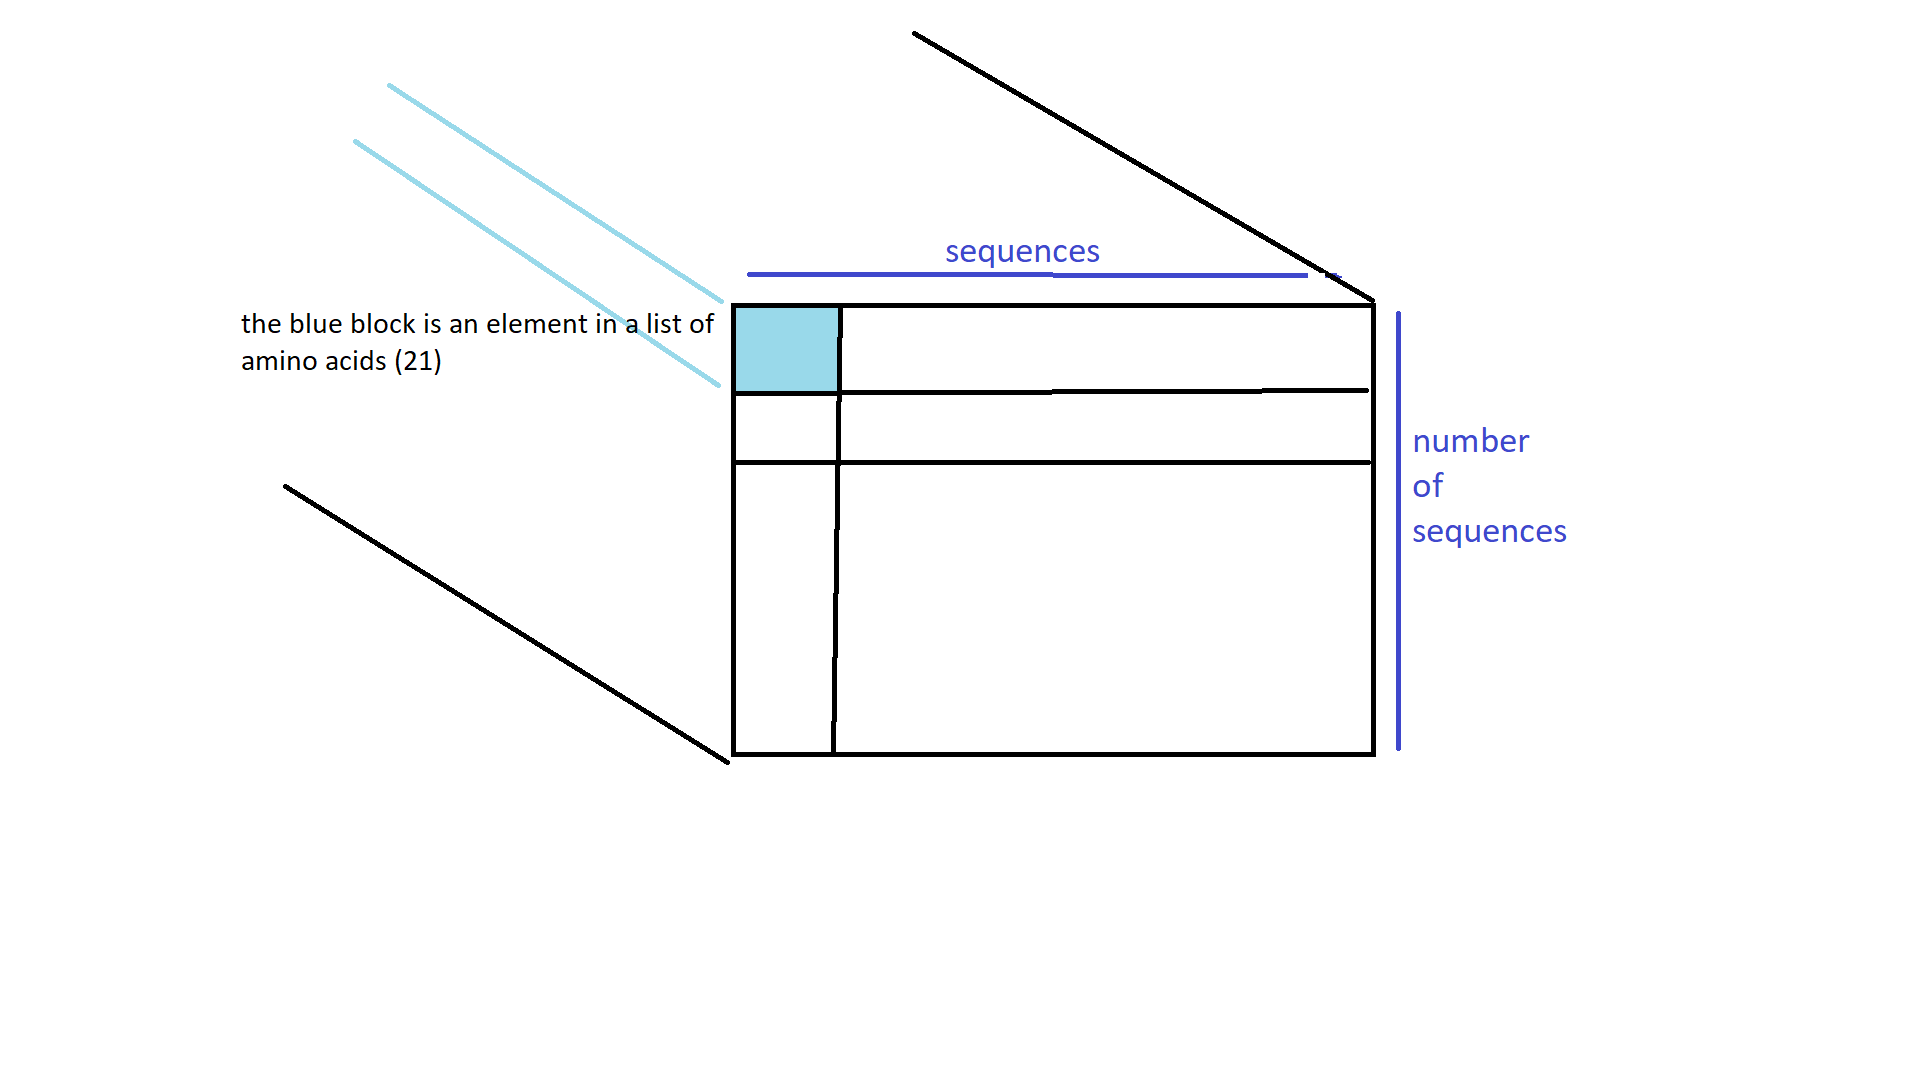

In [ ]:
sequences = read_fas_file(file_name)
i = 0

for key, value in sequences.items():
  print(f"{key}:{value}")
  c = len(value)
  print(c)
  print()
  i+=1
print(i) #107 sequences
#length of each sequence is 146


null:MEKGTVKWFNNAKGFGFICPEGGGEDIFAHYSTIQMDGYRTLKAGQSVQFDVHQGPKGNHASVIVPVEVEAAVAMAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR
146

B595494_C4L949_C4L946_3:MATGTVKWFNNAKGFGFICPDEGGDDIFAHYSTIDMNGYKTLKAGQPVEFEVQAGPKGSHATSIVP-T------MSKEDSIEMQGTILETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVQLTPYDLSKGRIVFRSR
146

B379066_C1A9Q1_C1A9Q0_1:RTTGTVKWFNDAKGFGFITPSDGQKDCFVHHSAIQGNGFKSLTEGETVEFDIVQGQKGPAAENVTRS--------MKQDMIEFEGVVTDVLPSTMFRVKLENDHEVLSTVAGKMRKFRIRILAGDRVTVEVSPYDLSRGRITFRHK
146

B879295_F3M1B2_F3M099_13:MRTGIVKQFDSRSPYGFIEDDLTGASYFVFYKSIKESGYKRLEVGQRVRYQLAQGKKGLQCINVYNN-------MAKEDVIEVEGKVIDTLPNAMFKVELENGATILAHVSGKIRMHYIRILPGDRVTVELSPYDLTKGRITYRFK
146

B563178_B8D9B2_B8D9A5_7:-IKGQVKWFNESKGFGFITPSDGSKDVFVHFSSIQGNGFKTLTEGQNVEFEIQDGQKGPAAVNVFSL-------MSKEENIEMQGVVIDTLPNTMFRVELENKHIVTAHISGKMRKNYIRILTGDKVTVELTPYDLTKGRIIFRSR
146

B937450_F1VYF6_F1VYD7_19:MATGTVKWFNDSKGFGFITPDDGGEDLFAHFSAIQMNGFKTLKEGQKVQFEVTQGPKGKQASNIQAP-------MAKDDVIQMQGEILENLPNATFRVKLENGHVVLGHISGK

In [ ]:
# Based on above we know that length of each sequence is 146 and there are 107 sequences in our file
sequence_length = 146
list_seq = [seq[:sequence_length] for seq in sequences.values()]

# Create a dictionary to map amino acids to indices
# we use enumerare to keep track of iteratables and their index; Mostly its a way to match 2 variables in a loop with eachother
aa_to_index = {aa: i for i, aa in enumerate(Amino_Acids)}

# Initialize the sequence matrix with zeros
seq_matrix = np.zeros((len(list_seq), sequence_length, len(Amino_Acids))) #rows, columns, depth -> a cube for all the sequences

''' ONE HOT ENCODING: '''
#sets the corresponding entry in the seq_matrix to 1, representing the presence of that amino acid in the sequence

# Iterate through each sequence
for i, seq in enumerate(list_seq):
    # Iterate through each amino acid in the sequence
    for j, aa in enumerate(seq):
        # Get the index of the amino acid from the dictionary
        aa_index = aa_to_index[aa]
        # Set the corresponding entry in the sequence matrix to 1
        seq_matrix[i, j, aa_index] = 1

data_onehot = seq_matrix

"""
seq_matrix is the whole sequences with a depth of amino acid reprasentation.
when doing the one hot encoding, we want each element in row,col, depth to represent a specific amino acid.
so for example, if the element in the matrix is M, that element is basically a list of 21 elements itself but now everything
is set to 0 but M is 1.

"""


' seq_matrix is the whole sequences with a depth of amino acid reprasentation.\nwhen doing the one hot encoding, we want each element in row,col, depth to represent a specific amino acid.\nso for example, if the element in the matrix is M, that element is basically a list of 21 elements itself but now everything\nis set to 0 but M is 1.\n\n'

Integer Encoding:
Integer encoding assigns a unique integer value to each category or class. The encoding is typically done based on the order or frequency of occurrence of the categories. For example, if we have three Amino acids : "A", "D", and "W", we can assign them integer values such as 0, 1, and 2, respectively. Integer encoding is straightforward to implement and requires less memory compared to one-hot encoding since it represents each category with a single integer value. However, integer encoding does not preserve any inherent relationships or similarities between the categories.

In [ ]:
'''

#INTEGER ENCODING
# Iterate through each sequence
for i, seq in enumerate(list_seq):
    # Iterate through each amino acid in the sequence
    for j, aa in enumerate(seq):
        # Get the index of the amino acid from the dictionary
        aa_index = aa_to_index[aa]
        # Set the corresponding entry in the sequence matrix to the index
        seq_matrix[i, j] = aa_index

data_integer = seq_matrix
'''

'\n\n#INTEGER ENCODING\n# Iterate through each sequence\nfor i, seq in enumerate(list_seq):\n    # Iterate through each amino acid in the sequence\n    for j, aa in enumerate(seq):\n        # Get the index of the amino acid from the dictionary\n        aa_index = aa_to_index[aa]\n        # Set the corresponding entry in the sequence matrix to the index\n        seq_matrix[i, j] = aa_index\n\ndata_integer = seq_matrix\n'

In [ ]:
"""
#VISUALIZATION(if you want to check integer encoding, comment one hot and uncomment integer )
data_onehot.shape
#show the selected sequence for comparison(second sequence is chosen )
print(list_seq[2])
#print the second row( second sequence in our file) and first column(first amino acid in the second sequence)
print(seq_matrix[2][0])
print()
#for more comparison, show the amino acids list
print(Amino_Acids)
"""

'\n#VISUALIZATION(if you want to check integer encoding, comment one hot and uncomment integer )\ndata_onehot.shape\n#show the selected sequence for comparison(second sequence is chosen )\nprint(list_seq[2])\n#print the second row( second sequence in our file) and first column(first amino acid in the second sequence) \nprint(seq_matrix[2][0])\nprint()\n#for more comparison, show the amino acids list\nprint(Amino_Acids)\n'

the list ebove is showing that the first letter in the chosen sequence (second seq) is encoded by one hot encoding correctly.The first letter of the sequence is R and in onehot encoding, the list is all 0's but only the R element is 1. so it is working correctly.

In [ ]:
"""
#for visualisation, comment out this part
c=0
for i in list_seq:
  print(i)
  c+=1
print(c) #107
"""

MEKGTVKWFNNAKGFGFICPEGGGEDIFAHYSTIQMDGYRTLKAGQSVQFDVHQGPKGNHASVIVPVEVEAAVAMAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR
MATGTVKWFNNAKGFGFICPDEGGDDIFAHYSTIDMNGYKTLKAGQPVEFEVQAGPKGSHATSIVP-T------MSKEDSIEMQGTILETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVQLTPYDLSKGRIVFRSR
RTTGTVKWFNDAKGFGFITPSDGQKDCFVHHSAIQGNGFKSLTEGETVEFDIVQGQKGPAAENVTRS--------MKQDMIEFEGVVTDVLPSTMFRVKLENDHEVLSTVAGKMRKFRIRILAGDRVTVEVSPYDLSRGRITFRHK
MRTGIVKQFDSRSPYGFIEDDLTGASYFVFYKSIKESGYKRLEVGQRVRYQLAQGKKGLQCINVYNN-------MAKEDVIEVEGKVIDTLPNAMFKVELENGATILAHVSGKIRMHYIRILPGDRVTVELSPYDLTKGRITYRFK
-IKGQVKWFNESKGFGFITPSDGSKDVFVHFSSIQGNGFKTLTEGQNVEFEIQDGQKGPAAVNVFSL-------MSKEENIEMQGVVIDTLPNTMFRVELENKHIVTAHISGKMRKNYIRILTGDKVTVELTPYDLTKGRIIFRSR
MATGTVKWFNDSKGFGFITPDDGGEDLFAHFSAIQMNGFKTLKEGQKVQFEVTQGPKGKQASNIQAP-------MAKDDVIQMQGEILENLPNATFRVKLENGHVVLGHISGKMRMNYIRILPGDKVTVELTPYDLSRARIVFRTK
MACGKVKWFNNAKGFGFIVEDGCENDIFAHYSTIVMDGYKTLKAGQDVTFELEQGPKGLHAKNIALDGD-----MAKEDVIEMQGTVLDTLPNTMFRVELENGHVVVAHISGKMRKNY

Objective:
Our objective is to utilize a collection of sequences and amino acid representations arranged in a cube to train an autoencoder. The aim is to compress the data effectively while minimizing data loss during decoding. To assess the performance of our model, we will evaluate the accuracy of both the input and output, along with analyzing the training and validation errors. This comprehensive analysis will provide valuable insights into the functioning of our model.

In [ ]:
from tensorflow.keras.metrics import MeanSquaredError

# Define input shape
input_shape = (146, 21)

# Define input layer
inputs = Input(shape=input_shape)

# Convolutional encoder
x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)
print(encoded)

# Dense decoder
x = Flatten()(encoded)  # Flatten sequence alignment to a 1D array
x = Dense(encoding_dim, activation='relu')(x)
x = Dense(146 * 21, activation='sigmoid')(x)
decoded = Reshape((146, 21))(x)  # Reshape back to a 3D array

# Define the autoencoder model
autoencoder = Model(inputs, decoded)

# Compile the model
autoencoder.compile(optimizer=Optimizer, loss='mse', metrics=[MeanSquaredError()])


KerasTensor(type_spec=TensorSpec(shape=(None, 37, 16), dtype=tf.float32, name=None), name='max_pooling1d_7/Squeeze:0', description="created by layer 'max_pooling1d_7'")


In [ ]:
from sklearn.model_selection import train_test_split

#we continue working with one hot encoding in the training section

# 1. Split data into training and testing sets (optional)
data_train, data_test = train_test_split(data_onehot, test_size=0.2, random_state=42)
print(data_train)
# 2. Train the model using the `fit` method
# Since it's an autoencoder, we use the same data for input and target

history = autoencoder.fit(data_train, data_train,
                          epochs=Epochs,  # Number of training epochs
                          batch_size=Batch_size,  # Batch size
                          shuffle=True,  # Shuffle data before each epoch
                          validation_data=(data_test, data_test))  # Validation data (optional)

# 3. Generate output using the `predict` method
# Let's use `data_test` as an example for generating output
decoded_output = autoencoder.predict(data_test)

# Now, `decoded_output` contains the reconstructed data
# Calculate similarity percentage
decoded_output = autoencoder.predict(data_test)
mse = np.mean(np.square(data_test - decoded_output))
percentage_similarity = (1 - mse) * 100

print(f"Percentage similarity: {percentage_similarity}%")

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Epoch 1/80

the code below is VAE:
adding a layer so it can check previous data of the model can help it to learn better

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
# Define input shape
input_shape = (146, 21)

# Define input layer
inputs = Input(shape=input_shape)

# Convolutional encoder
x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# Flatten the encoded representation
x = Flatten()(encoded)

# Define the mean and log variance layers
latent_dim = 10  # Dimensionality of the latent space
mean = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    mean, log_var = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return mean + K.exp(0.5 * log_var) * epsilon

# Apply the reparameterization trick
z = Lambda(sampling)([mean, log_var])

# Define the decoder layers
x = Dense(146 * 21, activation='relu')(z)
decoded = Reshape((146, 21))(x)

# Define the VAE model
vae = Model(inputs, decoded)

# Define the custom loss function
def vae_loss(inputs, decoded):
    reconstruction_loss = K.mean(K.square(inputs - decoded), axis=[1, 2])
    kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
    return reconstruction_loss + kl_loss

# Compile the VAE model
vae.compile(optimizer=Optimizer, loss=vae_loss, experimental_run_tf_function=False)


In [ ]:
type(data_onehot)

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split

#we continue working with one hot encoding in the training section

# 1. Split data into training and testing sets
data_train, data_test = train_test_split(data_onehot, test_size=0.2, random_state=42)
print(data_train)
# 2. Train the model using the `fit` method
# Since it's an autoencoder, we use the same data for input and target

history = vae.fit(data_train, data_train,
                          epochs=Epochs,  # Number of training epochs
                          batch_size=Batch_size,  # Batch size
                          shuffle=True,  # Shuffle data before each epoch
                          validation_data=(data_test, data_test))  # Validation data (optional)

# 3. Generate output using the `predict` method
# Let's use `data_test` as an example for generating output
decoded_output = vae.predict(data_test)

# Now, `decoded_output` contains the reconstructed data
# Calculate similarity percentage
decoded_output_var = vae.predict(data_test)
mse = np.mean(np.square(data_test - decoded_output))
percentage_similarity = (1 - mse) * 100

print(f"Percentage similarity: {percentage_similarity}%")

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Train on 8

In [ ]:
np.set_printoptions(suppress=True)
#each element in 1 array which is decoded_output is 1 sequence that is encoded that each row is a letter in a sequence
#and columns are is the amino acid letters
print(list_seq[1])

max_decoded = max(decoded_output[1][1])
final_output = dict(zip(Amino_Acids,decoded_output[1][1]))

max_var=max(decoded_output_var[1][1])
final_output_var = dict(zip(Amino_Acids,decoded_output_var[1][1]))

print(final_output)
print(max_var)

max_key, max_value = max(final_output.items(), key=lambda x: x[1])
max_key_var, max_value_var = max(final_output_var.items(), key=lambda x: x[1])

print(f"The amino acid with the maximum quantity is {max_key} with a value of {max_value}.")
print(f"The amino acid with the maximum quantity is {max_key_var} with a value of {max_value_var}.")


MATGTVKWFNNAKGFGFICPDEGGDDIFAHYSTIDMNGYKTLKAGQPVEFEVQAGPKGSHATSIVP-T------MSKEDSIEMQGTILETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVQLTPYDLSKGRIVFRSR
{'A': 0.36626858, 'C': 0.0, 'D': 0.017393995, 'E': 0.09875726, 'F': 0.0, 'G': 0.0, 'H': 0.0, 'I': 0.047631405, 'K': 0.0, 'L': 0.07397378, 'M': 0.035505913, 'N': 0.0, 'P': 0.10971627, 'Q': 0.0, 'R': 0.0, 'S': 0.0, 'T': 0.06298511, 'V': 0.0, 'W': 0.0, 'Y': 0.0, '-': 0.114936024}
0.2710613
The amino acid with the maximum quantity is A with a value of 0.3662685751914978.
The amino acid with the maximum quantity is A with a value of 0.2710613012313843.


As we can see, both of our models predicted the second element in the sequence correctly (A).
Notice that the training dataset is too small for models to have the best performance possible. By adding more data to the training set, we can improve the predictions and overcome overfitting.
